In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA

from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter, landscape
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
import os
# Define the title for the entire PDF
pdf_title = "15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13"
# Define the base directory
base_dir = '/home/jwm/data/fluorescence_plots/'
# Construct the figure directory path
figure_dir = os.path.join(base_dir, pdf_title)
# Ensure the figure directory exists
os.makedirs(figure_dir, exist_ok=True)# Directory for joined pdfs
# Directory for joined pdfs
output_dir = '/home/jwm/data/fluorescence_plots/fluorescence_data_overview_21_may_2024/'
os.makedirs(output_dir, exist_ok=True)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 999]


Enter the titles to include (separated by space), and ranges separated by '-':  1-31


               0        1        2        3        4        5        6     \
wavelength  470.000  470.100  470.200  470.300  470.400  470.500  470.600   
1           422.133  422.080  422.001  422.677  422.674  423.366  423.945   
2           430.678  430.750  430.611  430.576  431.168  431.548  432.151   
3           450.852  451.132  450.860  450.746  451.085  451.663  450.919   
4           481.424  480.964  480.967  481.392  481.924  482.175  482.114   
5           507.471  506.840  506.335  506.334  506.449  506.126  506.526   
6           526.969  526.571  526.717  525.896  525.897  525.749  525.969   
7           497.047  496.236  496.101  495.493  495.437  495.662  495.901   
8           500.049  499.729  499.425  499.403  498.328  498.556  498.277   
9           463.171  463.061  462.858  462.745  462.470  462.799  461.820   
10          420.340  419.422  419.004  419.392  419.020  418.789  419.172   
11          383.596  383.492  382.942  382.744  381.992  381.483  381.153   

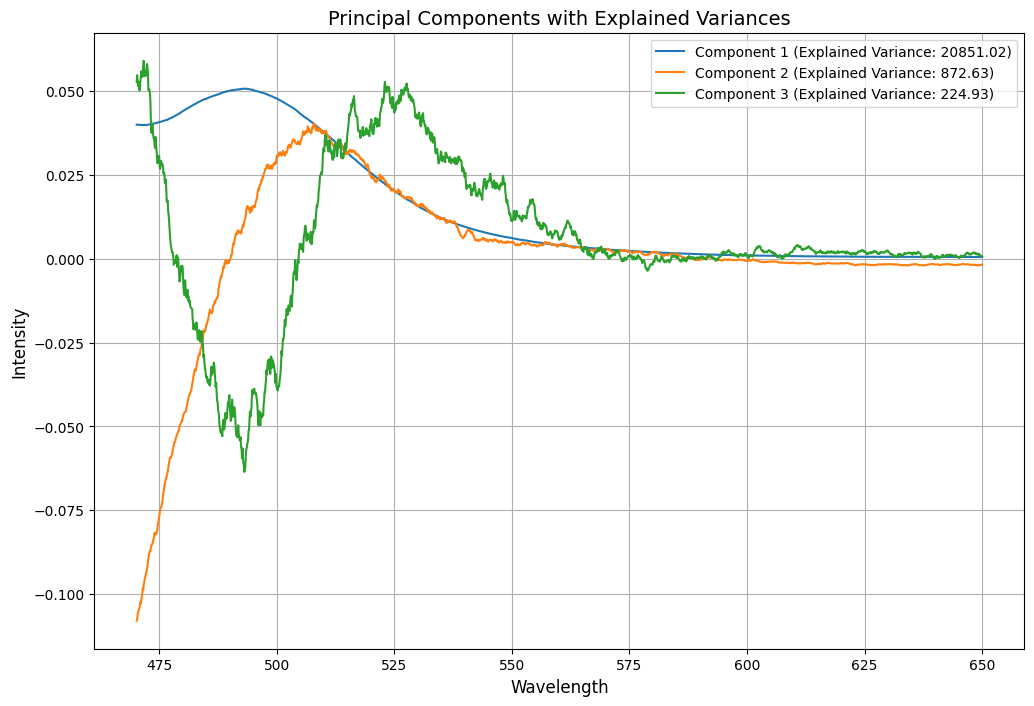

[[ 0.04001801  0.04000301  0.03999731 ...  0.00054126  0.00054089
   0.00054264]
 [-0.10796398 -0.10759229 -0.10621958 ... -0.00179498 -0.00179444
  -0.00172904]
 [ 0.05275325  0.05479877  0.05294642 ...  0.00078643  0.00063139
   0.00069687]]
[470.2 470.3 470.4 ... 649.8 649.9 650. ]


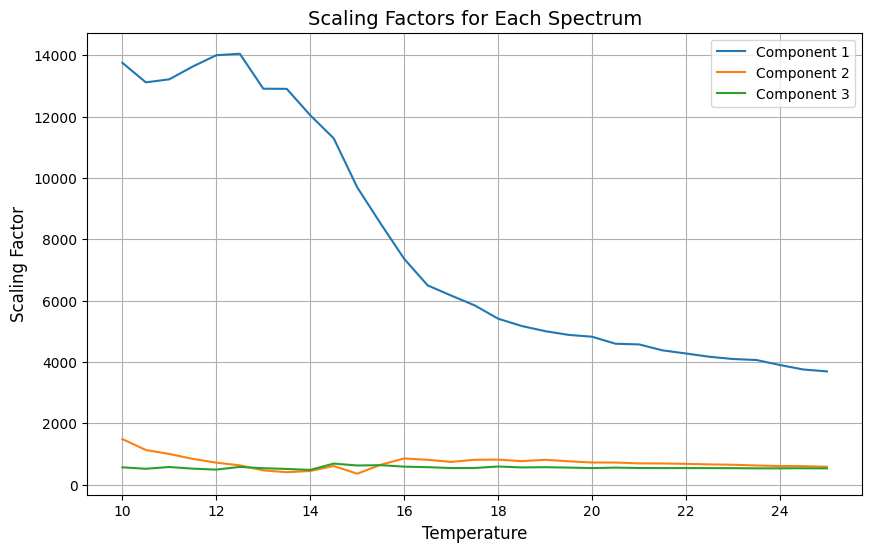

Explained variance in selected data for each component after rotation: [0.0227492  0.08725081 0.88995068]
/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/rotated_components_with_explained_variances.svg


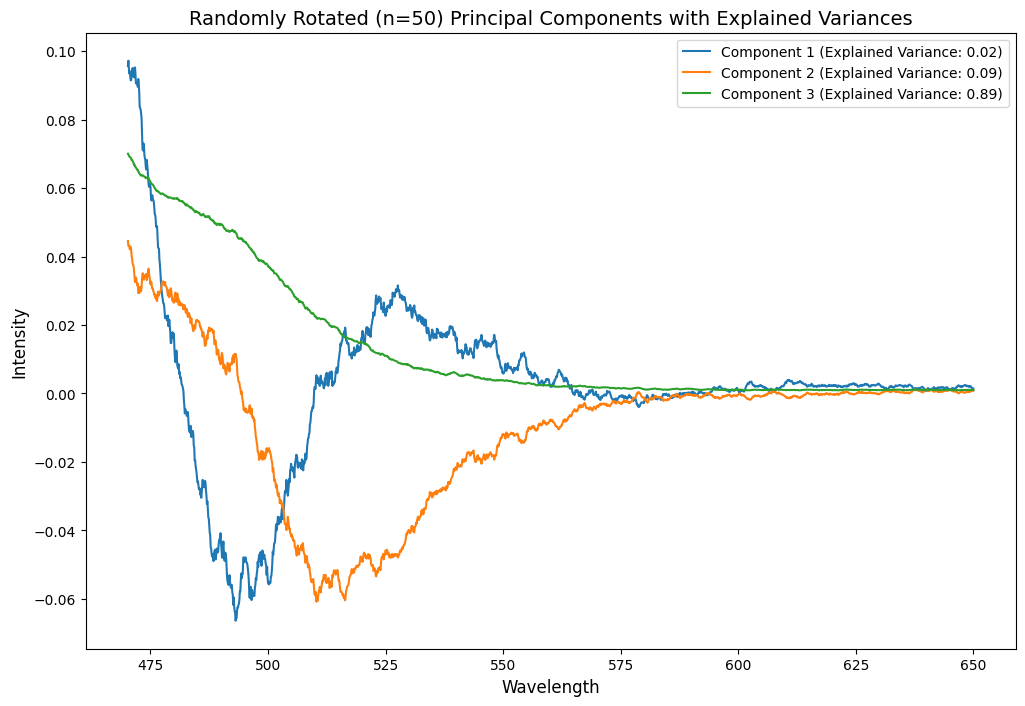

Best rotation is: [[0.09567627 0.09718924 0.09491402 ... 0.00153275 0.00140304 0.00142273]
 [0.04451218 0.04310195 0.04304102 ... 0.00082512 0.00090987 0.00082205]
 [0.07003773 0.06982636 0.06945868 ... 0.00105036 0.00105587 0.00103428]]
/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/rotated_component_scaling_factor_time_course.svg


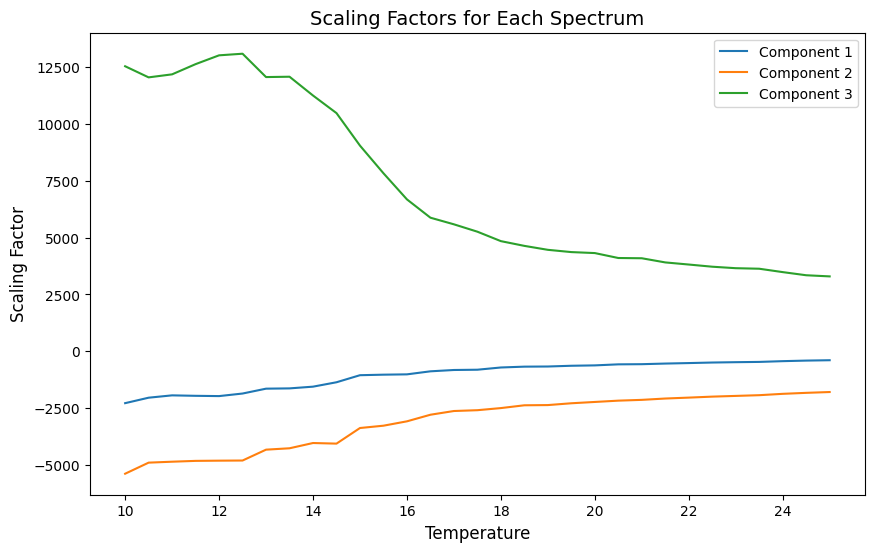

In [3]:
# Set the directory where your data files are located
data_dir = '/home/jwm/data/JASCO_FP_6500_Spectrofluorometer/2024april13_50mM_DAB2_418_630_150mM_NaCl_1DCVJ_slow_hysteresis/'

# Set the number of the first and last spectrum to use in the plot -1
first_spectrum = 0
last_spectrum = 30

# Define the range of titles you want to load
start_title = 7
end_title = 30

# Define the position of the box
box_x = 10
box_y = 300

titles = []

# Function to load (x, y) data from txt file starting from the 19th line
def load_data(file_path):
    return np.loadtxt(file_path, skiprows=18)

# Get all txt files in the directory
data_files = glob.glob(data_dir + "*.txt")

# Initialize a list to store loaded data
loaded_data = []

# Initialize variables for baseline data
baseline_data = None
baseline_title = None

# Load data from each file
for file_path in data_files:
    loaded_data.append(load_data(file_path))

# Extract 6th to 4th last digits from file name and use as title
titles = [int(file_path.split('/')[-1].split('.')[0][-7:-4]) for file_path in data_files]

# print(titles)

# Sort the titles and data_files in ascending order
sorted_indices = np.argsort(titles)
titles = [titles[i] for i in sorted_indices]
data_files = [data_files[i] for i in sorted_indices]
loaded_data = [loaded_data[i] for i in sorted_indices]

# Extract x-values from the first spectrum in loaded_data
wavelengths = loaded_data[0][2:, 0].astype(float)
    
# Check if file name contains "999" and assign it as baseline data
if "999" in file_path:
    baseline_data = loaded_data[-1]
    baseline_title = title

# Sort the files by their title
data_files.sort(key=lambda x: int(x.split('/')[-1].split('.')[0][-6:-4]))

print(titles)
# print(loaded_data)

# Convert extracted digits back to temperature values
temperatures = [10 + i * 0.5 for i in range(len(titles))]


# Sample loaded_data structure
# loaded_data = [
#    np.array([[470.0, 422.133], [470.1, 422.08], [470.2, 422.001], [650.0, 7.49391]]),
#    np.array([[470.0, 430.678], [470.1, 430.75], [470.2, 430.611], [650.0, 7.97855]])
#]

# Function to create DataFrame
def create_dataframe(loaded_data, titles):  # spectra in rows
    # Initialize DataFrame with the first spectrum
    df = pd.DataFrame(loaded_data[0], columns=['wavelength', titles[0]])
    
    # Iterate over the remaining spectra and concatenate them to the DataFrame
    for i in range(1, len(loaded_data)):
        spectrum_df = pd.DataFrame(loaded_data[i], columns=['wavelength', titles[i]])
        df = pd.merge(df, spectrum_df, on='wavelength', how='outer')
    
    return df

# Example usage
# included_titles = [int(title) for title in input("Enter the titles to include (separated by space): ").split()]
# selected_data = [loaded_data[titles.index(title)] for title in included_titles]

title_inputs = input("Enter the titles to include (separated by space), and ranges separated by '-': ").split()
included_titles = [title for title_input in title_inputs for title in (list(range(int(title_input.split('-')[0]), int(title_input.split('-')[-1])+1)) if '-' in title_input else [int(title_input)])]

def get_selected_data(loaded_data, titles_input):
    selected_data = []
    selected_temperatures = []
    for title_input in titles_input:
        if '-' in str(title_input):
            start, end = map(int, title_input.split('-'))
            selected_data.extend(loaded_data[start-1:end])
            selected_temperatures.extend(temperatures[start-1:end])
        else:
            selected_data.append(loaded_data[int(title_input)-1])
            selected_temperatures.append(temperatures[int(title_input)-1])
    return selected_data, selected_temperatures
    
selected_data, selected_temperatures = get_selected_data(loaded_data, included_titles)

df = create_dataframe(selected_data, included_titles)
df = df.transpose()
print(df)


n_components=3

# Extract spectra and wavelengths
spectra = df.iloc[1:, 2:].values.astype(float)  # Convert to numpy array
# wavelengths = df.iloc[1, 2:].values.astype(float)
# wavelengths = df.columns[2:].astype(float)

def perform_pca(df, n_components):
    # Extracting the spectra data from the DataFrame
    spectra = df.values[2:, 2:]
    
    # Initialize PCA with the desired number of components
    pca = PCA(n_components=n_components)
    
    # Fit PCA to the spectra data
    pca.fit(spectra)
    
    # Get the explained variance ratio and singular values
    explained_variance_ratio = pca.explained_variance_ratio_
    singular_values = pca.singular_values_
    components = pca.components_
    
    return explained_variance_ratio, singular_values, components

# Example usage:
explained_variance_ratio, singular_values, components = perform_pca(df, n_components)

print(explained_variance_ratio)

def plot_singular_values(explained_variance_ratio, singular_values):
    # Plotting singular values
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(singular_values) + 1), singular_values, marker='o', linestyle='-')
    plt.xlabel('Component', fontsize=12)
    plt.ylabel('Singular Value', fontsize=12)
    plt.title('Singular Values for Each Component', fontsize=14)
    plt.grid(True)
    plt.show()

    
def calculate_scaling_factors(df, n_components, components):
    # Initialize scaling factors list
    scaling_factors = []
    max_length = 0
    
    for spectrum in spectra:
        # Objective function to minimize the reconstruction error
        def objective(x):
            reconstructed_spectrum = np.dot(components.T, x)
            return np.sum((spectrum - reconstructed_spectrum)**2)
        
        # Initial guess for the scaling factors
        x0 = np.ones(n_components)
        
        # Minimize the reconstruction error
        res = minimize(objective, x0)
        
        # Get the length of the optimized scaling factors
        length = len(res.x)
        max_length = max(max_length, length)
        
        # Append the optimized scaling factors to the list
        scaling_factors.append(res.x)
    
    # Pad shorter arrays with zeros to match the length of the longest array
    for i in range(len(scaling_factors)):
        scaling_factors[i] = np.pad(scaling_factors[i], (0, max_length - len(scaling_factors[i])), 'constant')
    
    return np.array(scaling_factors)


# Example usage:
scaling_factors = calculate_scaling_factors(df, n_components, components)
# print(scaling_factors)



def plot_components_with_explained_variances(components, explained_variance, wavelengths):
    plt.figure(figsize=(12, 8))
    for i, component in enumerate(components):
        plt.plot(wavelengths, component, label=f'Component {i+1} (Explained Variance: {explained_variance[i]:.2f})')

    plt.xlabel('Wavelength', fontsize=12)
    plt.ylabel('Intensity', fontsize=12)
    plt.title('Principal Components with Explained Variances', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_components_with_explained_variances(components, singular_values, wavelengths)

print(components)
print(wavelengths)


def plot_scaling_factors(scaling_factors, selected_temperatures, n_components):
    plt.figure(figsize=(10, 6))
    for i in range(n_components):
        scaling_factor_values = [factor[i] for factor in scaling_factors]
        plt.plot(selected_temperatures, scaling_factor_values, label=f'Component {i+1}')

    plt.xlabel('Temperature', fontsize=12)
    plt.ylabel('Scaling Factor', fontsize=12)
    plt.title('Scaling Factors for Each Spectrum', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_scaling_factors(scaling_factors, selected_temperatures, n_components)





def random_rotation(components):
    # Generate a random orthogonal matrix using QR decomposition
    q, _ = np.linalg.qr(np.random.randn(*components.shape))
    return q

def find_best_rotation(components, spectra):
    best_rotation = None
    min_error = float('inf')
    
    for _ in range(n_rotations):
        rotation_matrix = random_rotation(components)
        rotated_components = np.dot(rotation_matrix, components)
        
        # Calculate reconstruction error
        error = calculate_reconstruction_error(rotated_components, spectra)
        
        # Update best rotation if error is smaller
        if error < min_error:
            min_error = error
            best_rotation = rotated_components
    
    return best_rotation



def calculate_reconstruction_error(rotated_components, spectra):
    # Initialize scaling factors list
    scaling_factors = []
    x0 = np.ones(rotated_components.shape[0])  # Define x0 outside the function

#    print("Components shape:", components.shape)

    # Iterate over each spectrum
    for spectrum in spectra:
        # Objective function to minimize the reconstruction error
        def objective(x):
#            print("x shape:", x.shape)
#            print("Initial guess shape:", x0.shape)
            reconstructed_spectrum = np.dot(rotated_components.T, x)
            return np.sum((spectrum - reconstructed_spectrum)**2)

        # Minimize the reconstruction error
#        print("Initial guess shape:", x0.shape)
        res = minimize(objective, x0)
        
        scaling_factors.append(res.x)
    
    # Calculate total reconstruction error
    total_error = sum([objective(scaling_factors[i]) for i in range(len(scaling_factors))])
    
    return total_error

# Example usage:
n_rotations = 50
best_rotation = find_best_rotation(components, spectra)
# plot_components_with_explained_variances(best_rotation, singular_values, wavelengths)


def calculate_explained_variance(df, best_rotation):
    # Extract spectra from the DataFrame
    spectra = df.iloc[1:, 2:].values.astype(float)
    
    # Compute the covariance matrix of the spectra
    cov_matrix = np.cov(spectra, rowvar=False)
    
    # Calculate the total variance of the spectra
    total_variance = np.trace(cov_matrix)
    
    # Compute the variance explained by each component in the best rotation matrix
    component_variances = np.diag(np.dot(np.dot(best_rotation, cov_matrix), best_rotation.T))
    
    # Normalize the explained variance by dividing by the total variance
    explained_variance_rotated = component_variances / total_variance
    
    return explained_variance_rotated

# Example usage:
explained_variance_rotated = calculate_explained_variance(df, best_rotation)
print("Explained variance in selected data for each component after rotation:", explained_variance_rotated)


def calculate_scaling_factors_rotated(df, n_components, best_rotation):
    # Initialize scaling factors list
    scaling_factors_rotated = []
    max_length = 0
    
    for spectrum in spectra:
        # Objective function to minimize the reconstruction error
        def objective(x):
            reconstructed_spectrum = np.dot(best_rotation.T, x)
            return np.sum((spectrum - reconstructed_spectrum)**2)
        
        # Initial guess for the scaling factors
        x0 = np.ones(n_components)
        
        # Minimize the reconstruction error
        res = minimize(objective, x0)
        
        # Get the length of the optimized scaling factors
        length = len(res.x)
        max_length = max(max_length, length)
        
        # Append the optimized scaling factors to the list
        scaling_factors_rotated.append(res.x)
    
    # Pad shorter arrays with zeros to match the length of the longest array
    for i in range(len(scaling_factors_rotated)):
        scaling_factors_rotated[i] = np.pad(scaling_factors_rotated[i], (0, max_length - len(scaling_factors_rotated[i])), 'constant')
    
    return np.array(scaling_factors_rotated)



def plot_rotated_components_with_explained_variances(best_rotation, explained_variance_rotated, wavelengths):
    plt.figure(figsize=(12, 8))
    for i, component in enumerate(best_rotation):
        plt.plot(wavelengths, component, label=f'Component {i+1} (Explained Variance: {explained_variance_rotated[i]:.2f})')

    plt.xlabel('Wavelength', fontsize=12)
    plt.ylabel('Intensity', fontsize=12)
    plt.title(f'Randomly Rotated (n={n_rotations}) Principal Components with Explained Variances', fontsize=14)
    plt.legend()
    plt.grid(False)
    save_path = os.path.join(figure_dir, '4_rotated_components_with_explained_variances.svg')
    print(save_path)
    plt.savefig(save_path)    
    plt.show()

# Example usage:
plot_rotated_components_with_explained_variances(best_rotation, explained_variance_rotated, wavelengths)

print("Best rotation is:", best_rotation)



def plot_scaling_factors_rotated(scaling_factors_rotated, selected_temperatures, n_components):
    plt.figure(figsize=(10, 6))
    for i in range(n_components):
        scaling_factor_rotated_values = [factor[i] for factor in scaling_factors_rotated]
        plt.plot(selected_temperatures, scaling_factor_rotated_values, label=f'Component {i+1}')

    plt.xlabel('Temperature', fontsize=12)
    plt.ylabel('Scaling Factor', fontsize=12)
    plt.title('Scaling Factors for Each Spectrum', fontsize=14)
    plt.legend()
    plt.grid(False)
    save_path = os.path.join(figure_dir, '5_rotated_component_scaling_factor_time_course.svg')
    print(save_path)
    plt.savefig(save_path)   
    plt.show()

# Example usage:
scaling_factors_rotated = calculate_scaling_factors_rotated(df, n_components, best_rotation)
plot_scaling_factors_rotated(scaling_factors_rotated, selected_temperatures, n_components)


